# Stanford Cars Image Classification (Grab AI for SEA Challenge)

I'll be using `fastai` wonderful library using PyTorch for the solution.

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import pandas as pd
import numpy as np
from pathlib import Path
import json
from matplotlib import patches, patheffects
import matplotlib.pyplot as plt

import scipy.io as sio

In [2]:
from fastai import *
from fastai.vision import *

In [3]:
path = 'data/'

## Preprocessing

Preprocessed the data from .mat format files and create a dataframe to store the filenames, class names etc of all the data. Thanks to Devon Yates' code [here](https://www.kaggle.com/criticalmassacre/inaccurate-labels-in-stanford-cars-data-set).

In [92]:
train_annos_path = 'devkit/cars_train_annos.mat'
test_annos_path = 'cars_test_annos_withlabels.mat'
classes_path = 'devkit/cars_meta.mat'

def get_labels(annos_path, classes_path):
    car_annos = sio.loadmat(path + annos_path)
    car_meta = sio.loadmat(path + classes_path)
    annotations = car_annos["annotations"][0,:]
    nclasses = len(car_meta["class_names"][0])
    class_names = dict(zip(range(1,nclasses),[c[0] for c in car_meta["class_names"][0]]))
    
    labelled_images = {}
    dataset = []
    for i,arr in enumerate(annotations):
        # the last entry in the row is the image name
        # The rest is the data, first bbox, then classid
        dataset.append([y[0][0] for y in arr][0:5]+[arr[5][0]])
    # Convert to a DataFrame, and specify the column names
    temp_df = pd.DataFrame(dataset, 
                      columns =['BBOX_X1','BBOX_Y1','BBOX_X2','BBOX_Y2','ClassID','filename'])

    temp_df = temp_df.assign(ClassName=temp_df.ClassID.map(dict(class_names)))
    temp_df.columns = ['bbox_x1','bbox_y1','bbox_x2','bbox_y2','class_id','filename', 'class_name']
    return temp_df

In [93]:
train_df = get_labels(train_annos_path, classes_path)
train_df['is_test'] = 0
train_df.to_csv(path + 'train_labels.csv', index=False)

test_df = get_labels(test_annos_path, classes_path)
test_df['is_test'] = 1

# Add missing class name! - 'smart fortwo Convertible 2012'
train_df.loc[train_df['class_name'].isnull(), 'class_name'] = 'smart fortwo Convertible 2012'
test_df.loc[test_df['class_name'].isnull(), 'class_name'] = 'smart fortwo Convertible 2012'

frames = [train_df, test_df]
labels_df = pd.concat(frames)
labels_df.reset_index(inplace=True, drop=True)
labels_df = labels_df[['filename', 'bbox_x1', 'bbox_y1','bbox_x2','bbox_y2',
                            'class_id', 'class_name','is_test']]

# adjust the test file names
labels_df['filename'].loc[labels_df['is_test']==1] = labels_df['filename']

labels_df.to_csv(path + 'labels_with_annos.csv')
labels_df.head()

filename  bbox_x1  bbox_y1  bbox_x2  bbox_y2  class_id  \
0  00001.jpg       39      116      569      375        14   
1  00002.jpg       36      116      868      587         3   
2  00003.jpg       85      109      601      381        91   
3  00004.jpg      621      393     1484     1096       134   
4  00005.jpg       14       36      133       99       106   

                            class_name  is_test  
0                  Audi TTS Coupe 2012        0  
1                  Acura TL Sedan 2012        0  
2           Dodge Dakota Club Cab 2007        0  
3     Hyundai Sonata Hybrid Sedan 2012        0  
4  Ford F-450 Super Duty Crew Cab 2012        0

In [94]:
labels_df.loc[labels_df['is_test'] == 0, :].head()

filename  bbox_x1  bbox_y1  bbox_x2  bbox_y2  class_id  \
0  00001.jpg       39      116      569      375        14   
1  00002.jpg       36      116      868      587         3   
2  00003.jpg       85      109      601      381        91   
3  00004.jpg      621      393     1484     1096       134   
4  00005.jpg       14       36      133       99       106   

                            class_name  is_test  
0                  Audi TTS Coupe 2012        0  
1                  Acura TL Sedan 2012        0  
2           Dodge Dakota Club Cab 2007        0  
3     Hyundai Sonata Hybrid Sedan 2012        0  
4  Ford F-450 Super Duty Crew Cab 2012        0

In [23]:
labels_df['class_name'].nunique(), labels_df['class_id'].nunique() 

(196, 196)

In [24]:
labels_df.shape

(16185, 8)

Check wether number of images in train and test set is correct

In [25]:
(labels_df['is_test'] == 0).sum()

8144

In [26]:
(labels_df['is_test'] == 1).sum()

8041

Save the dataframe to a csv so it can be used again

In [95]:
labels_df.to_csv('labels.csv', index=False)

Create 2 functions, `compare_top_losses` and `compare_most_confused` to analyze results later.

In [26]:
def compare_top_losses(k, interp, labels_df, num_imgs):
    tl_val,tl_idx = interp.top_losses(k)
    classes = interp.data.classes
    probs = interp.probs
    columns = 2
    rows = 2
    
    topl_idx = 0   
    for i,idx in enumerate(tl_idx):
        fig=plt.figure(figsize=(10, 8))
        columns = 2
        rows = 1
        
        # Actual Image
        act_im, cl = interp.data.valid_ds[idx]
        cl = int(cl)        
        act_cl = classes[cl]
        act_fn = labels_df.loc[labels_df['class_name'] == act_cl]['filename'].values[0]
        
        # Predicted Image
        pred_cl = interp.pred_class[idx]
        pred_cl = classes[pred_cl]
        pred_fn = labels_df.loc[labels_df['class_name'] == pred_cl]['filename'].values[0]
        
        print(f'PREDICTION:{pred_cl}, ACTUAL:{act_cl}')
        print(f'Loss: {tl_val[i]:.2f}, Probability: {probs[i][cl]:.4f}')
              
        # Add image to the left column
        img_path = 'train/' + pred_fn
        im = plt.imread(path+img_path)
        fig.add_subplot(rows, columns, 1)
        plt.imshow(im)
        
        # Add image to the right column, need to change the tensor shape (permute) for matplotlib
        perm = act_im.data.permute(1,2,0)
        fig.add_subplot(rows, columns, 2)
        plt.imshow(perm)

        plt.show()

In [31]:
def compare_most_confused(most_confused, labels_df, num_imgs, rank):
    c1 = most_confused[:][rank][0]
    c2 = most_confused[:][rank][1]
    n_confused = most_confused[:3][0][1]
    print(most_confused[:][rank])
      
    # set the list of 
    f_1 = labels_df.loc[labels_df['class_name'] == c1]['filename'].values
    f_2 = labels_df.loc[labels_df['class_name'] == c2]['filename'].values

    fig=plt.figure(figsize=(10, 8))
    columns = 2
    rows = num_imgs
    for i in range(1, columns*rows +1, 2):
        # Add image to the left column
        img_path = 'cars_train/' + f_1[i]
        im = plt.imread(path+img_path)
        fig.add_subplot(rows, columns, i)
        plt.imshow(im)
        
        # Add image to the right column
        img_path = 'cars_train/' + f_2[i]
        im = plt.imread(path+img_path)
        fig.add_subplot(rows, columns, i+1)
        plt.imshow(im)

    plt.show()

## Preparing Data

We'll use fastai library for data augmentation on the images.

In [4]:
labels_df = pd.read_csv('labels.csv')

Prepare the training data, the data is split into 80/20 train/validation split.

In [74]:
SZ = 224
LABEL = 'class_name'

car_tfms = get_transforms()

trn_labels_df = labels_df.loc[labels_df['is_test']==0, ['filename', 'class_name', 'class_id']].copy()

src = (ImageList.from_df(trn_labels_df, path, folder='cars_train', cols='filename')
                    .split_by_rand_pct(valid_pct=0.2, seed=100)
                    .label_from_df(cols=LABEL))

data = (src.transform(car_tfms, size=SZ)
            .databunch()
            .normalize(imagenet_stats))

These are the type of transformations

In [34]:
help(get_transforms)

Help on function get_transforms in module fastai.vision.transform:

get_transforms(do_flip: bool = True, flip_vert: bool = False, max_rotate: float = 10.0, max_zoom: float = 1.1, max_lighting: float = 0.2, max_warp: float = 0.2, p_affine: float = 0.75, p_lighting: float = 0.75, xtra_tfms: Union[Collection[fastai.vision.image.Transform], NoneType] = None) -> Collection[fastai.vision.image.Transform]
    Utility func to easily create a list of flip, rotate, `zoom`, warp, lighting transforms.



Looking at few sample of images:

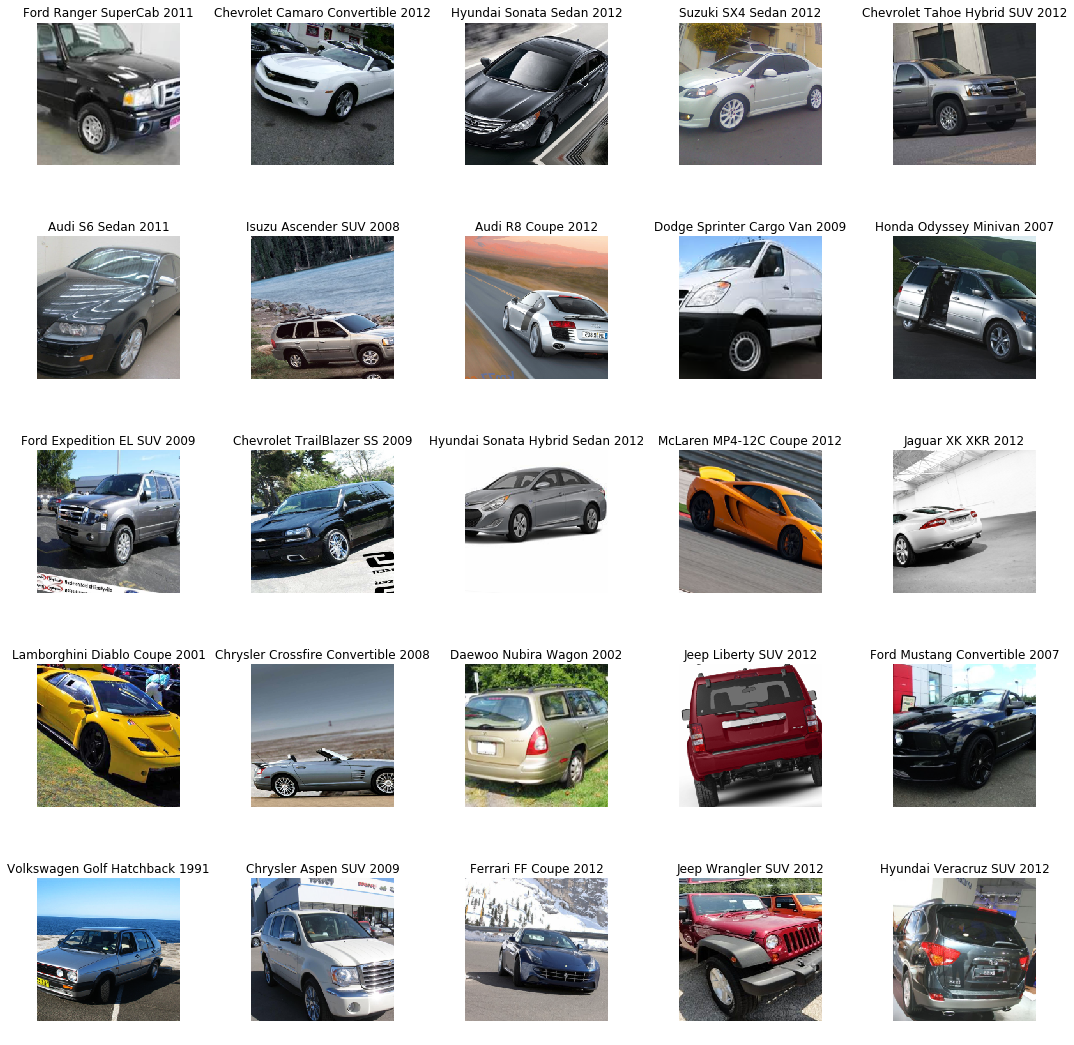

In [35]:
data.show_batch(rows=5, figsize=(15,15))

Dodge Dakota Club Cab 2007


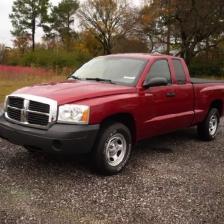

In [45]:
ds = data.train_ds

img,label = ds[2]
print(label)
img

## Modeling

I'll be using resnet152 architecture for the model as it's proven to do great job on image classification. For hyperparameters tuning, only learning rate and number of epochs will only be tuned.

### Stage 1

In [75]:
arch = models.resnet152

Using batch size 32 as 64 is too much, we'll run out of memory.

In [53]:
data.batch_size = 32
data.batch_size

32

Create a `Learner` using the resnet152 model, data above and accuracy as the metrics.

In [76]:
learn = cnn_learner(data, arch, metrics=[accuracy])

Using fastai learning rate finder to get the best learning rate. Learning rate is chosen at the point a bit before the minimum where the loss still improves.

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


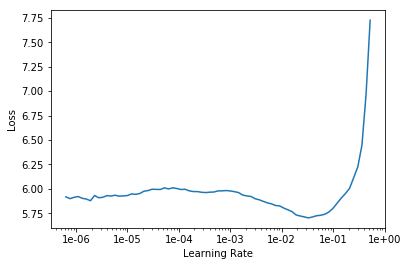

In [9]:
learn.lr_find()
learn.recorder.plot()

In [10]:
lr = 1e-2

Using [1-cycle policy](https://arxiv.org/pdf/1803.09820.pdf) from Leslie Smith. Implement using fastai library. Initializing the first stage training.

In [11]:
learn.fit_one_cycle(4, max_lr = lr)

Accuracy is still increasing. Need to increase number of epochs to train more as the training loss is higher than validation loss.

In [12]:
learn.fit_one_cycle(16, max_lr = lr)

In [13]:
learn.save('stage-1')

### Stage 2

Unfreeze all layers to fine tune earlier layers.

In [14]:
learn.unfreeze()

Need to change the batch size because ran out of memory.

In [77]:
data.batch_size = 16
data.batch_size

16

Finding the best learning rate

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


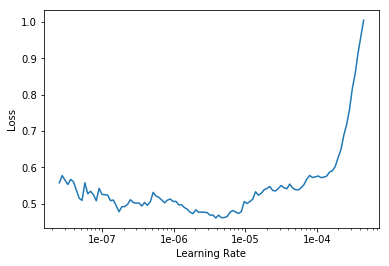

In [16]:
learn.lr_find(start_lr=1e-8, end_lr=9e-1, num_it=200)
learn.recorder.plot()

Using lower learning rate and 10 epochs

In [17]:
data.batch_size = 16

lr = 1e-3

learn.fit_one_cycle(10, lr)

Save all the models after training so that they can be loaded again if needed.

In [18]:
learn.save('stage_2_no_diff_lr')

Using differential learning rate. Differential Learning rates mean higher layers change more than deeper layers during training. The last layers of the model will often need the most changing, while deeper levels that are already well trained to detecting basic features (such as edges and outlines) will need less.

In [20]:
learn.load('stage-1')
learn.unfreeze()
lr = 1e-3
lrs = np.array([lr/9,lr/6,lr])
learn.fit_one_cycle(12, lrs)

In [ ]:
learn.save('stage2_diff_lr_9_12')

In [21]:
learn.load('stage-1')
learn.unfreeze()
lr = 1e-3
lrs = np.array([lr/9,lr/6,lr])
learn.fit_one_cycle(15, lrs)

In [25]:
learn.save('stage2_diff_lr_9_15')

In [47]:
learn.load('stage-1')
learn.unfreeze()
lr = 1e-3
lrs = np.array([lr/100,lr/10,lr])

In [48]:
learn.fit_one_cycle(11, lrs)

In [49]:
learn.save("stage2_diff_lr_100_12")

In [29]:
learn.load('stage-1')
learn.unfreeze()
lr = 1e-2
lrs = np.array([lr/9,lr/6,lr])
learn.fit_one_cycle(15, lrs)

In [30]:
learn.save("stage2_diff_lr-2_100_12")

Using learning rate 0.01 is too high as the loss is very high.<br><br>
The best model for stage 2 is using differetial learning rate 9, learning rate 1e-3, and 15 epochs. The model will be used for stage 3.

### Stage 3

In [5]:
SZ = 299
LABEL = 'class_name'

car_tfms = get_transforms()

trn_labels_df = labels_df.loc[labels_df['is_test']==0, ['filename', 'class_name', 'class_id']].copy()

src = (ImageList.from_df(trn_labels_df, path, folder='cars_train', cols='filename')
                    .split_by_rand_pct(valid_pct=0.2, seed=100)
                    .label_from_df(cols=LABEL))

data = (src.transform(car_tfms, size=SZ)
            .databunch()
            .normalize(imagenet_stats))

In [6]:
data.batch_size = 16
arch = models.resnet152
learn = cnn_learner(data, arch, metrics=[accuracy])

In [10]:
learn.load('stage2_diff_lr_9_15')
learn.freeze()
lr=1e-3
learn.fit_one_cycle(8, lr)

In [11]:
learn.save('stage3-8epoch')

In [12]:
learn.load('stage2_diff_lr_9_15')
learn.freeze()
lr=1e-3
learn.fit_one_cycle(7, lr)

In [14]:
learn.save('stage3-7epoch')

In [59]:
learn.load('stage2_diff_lr_9_15')
learn.freeze()
lr=1e-2
learn.fit_one_cycle(7, lr)

In [60]:
learn.save('stage3_high_lr_7epochs')

In [69]:
learn.load('stage2_diff_lr_9_15')
learn.freeze()
lr=3e-3
learn.fit_one_cycle(8, lr)

In [ ]:
learn.save('stage3_lr_0.003')

So accuracy increase for this model but looking at the train loss and validation loss, there seems to be sign of overfitting. The train loss is very low, in fact it's lowest but the validation loss a bit high, highest between all models in stage 3. So, I'm choosing the first model with lr=0.001 and 8 number of epochs.

## Testing

Testing the model on test set by setting the test set as valid set using the same `databunch`.

In [7]:
SZ = 299
LABEL = 'class_name'

car_tfms = get_transforms()


src = (ImageList.from_df(labels_df, path, folder='cars_test', cols='filename')
       # the 'is_test' column has values of 1 for the test set
       .split_from_df(col='is_test')
       .label_from_df(cols=LABEL))

data_test = (src.transform(car_tfms, size=SZ)
            .databunch(no_check=True)
            .normalize(imagenet_stats))

In [8]:
arch = models.resnet152

In [9]:
learn = cnn_learner(data, arch, metrics=[accuracy])

Using Test-Time-Augmentation for the testing:

In [10]:
learn.load('stage3-8epoch')
learn.data = data_test
test_preds, test_ys = learn.TTA()
accuracy = accuracy(test_preds, test_ys)
print(f'accuracy: {accuracy*100:.2f}%')

accuracy: 88.27%


The test set accuracy is **88.27%**

## Results

It's time to check the model performance, where does the model did poorly

In [70]:
arch = models.resnet152
learn = cnn_learner(data, arch, metrics=[accuracy])
learn.load('stage3-8epoch')

# Load the last data that was used to train the stage-3 model
learn.data = data

In [71]:
interp = ClassificationInterpretation.from_learner(learn)

Let's check the top 9 wrong predictions:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


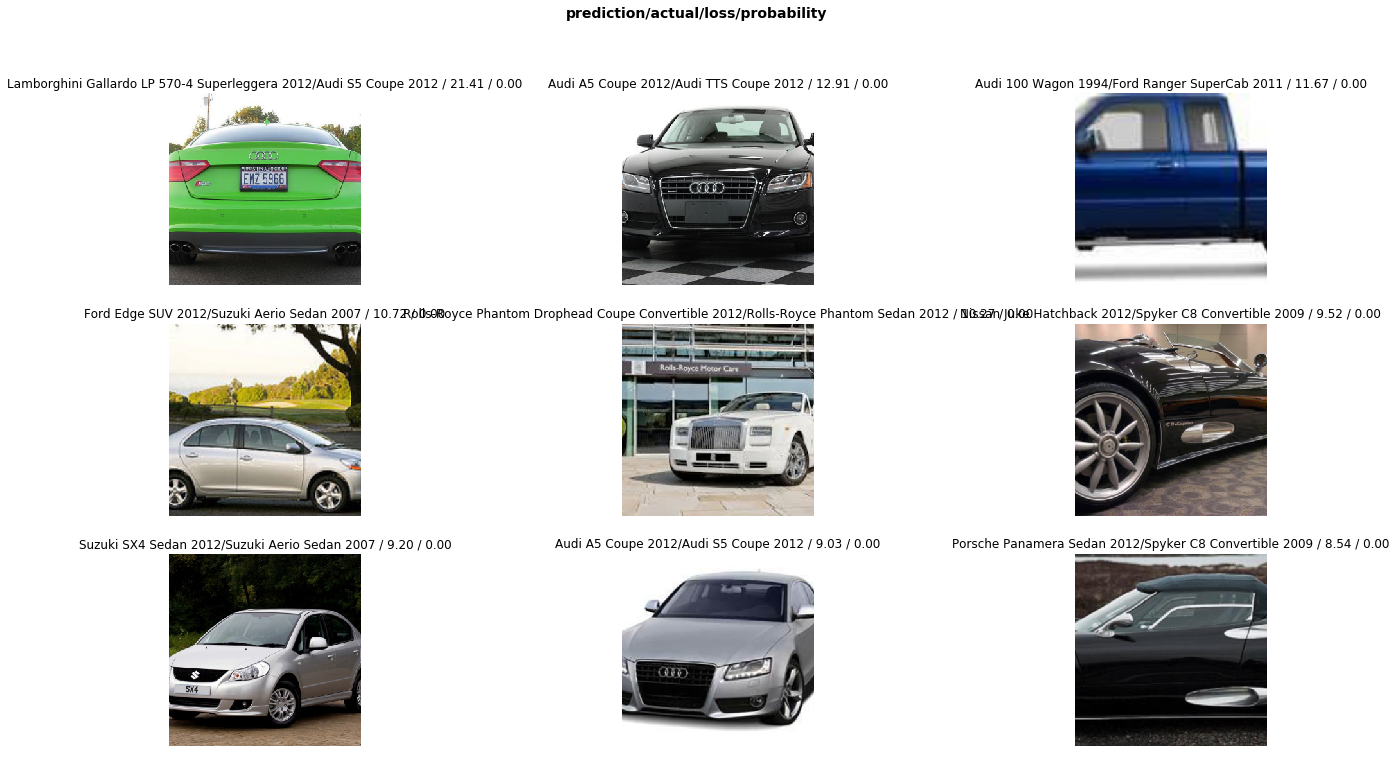

In [72]:
interp.plot_top_losses(9, figsize=(23,12), heatmap=False)

Let's look at the top confused images from the model. All the confused images are from cars that look very similar.

('Bentley Continental GT Coupe 2012', 'Bentley Continental GT Coupe 2007', 4)


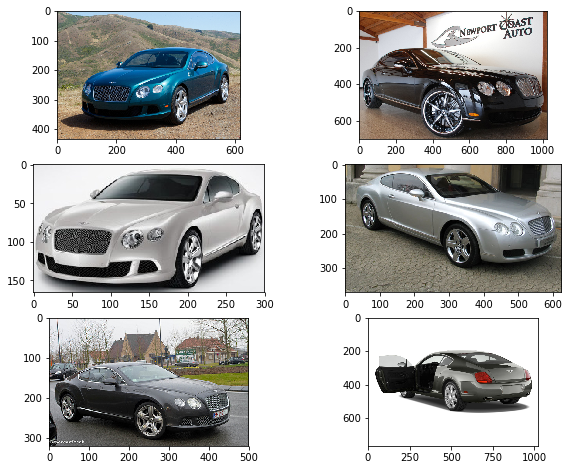

('Chevrolet Silverado 1500 Extended Cab 2012', 'Chevrolet Silverado 1500 Hybrid Crew Cab 2012', 4)


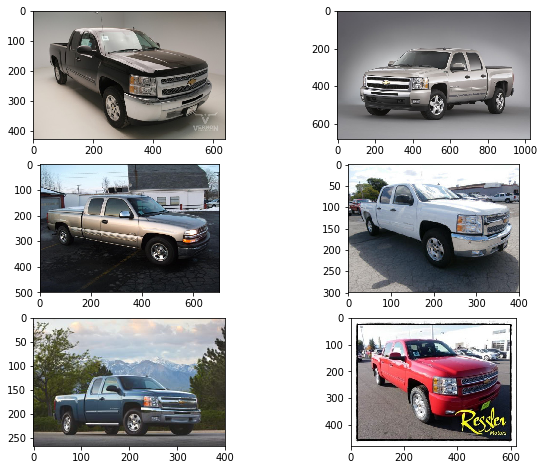

('Aston Martin V8 Vantage Convertible 2012', 'Aston Martin V8 Vantage Coupe 2012', 3)


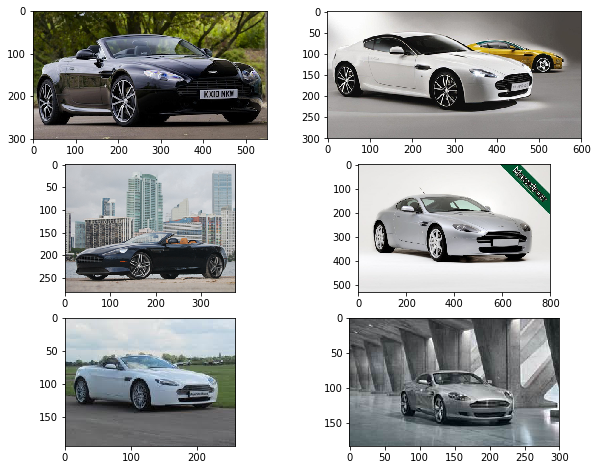

('Audi TTS Coupe 2012', 'Audi TT Hatchback 2011', 3)


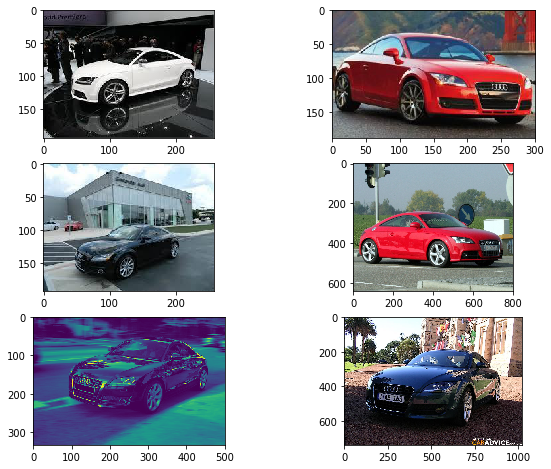

('Chevrolet Express Van 2007', 'Chevrolet Express Cargo Van 2007', 3)


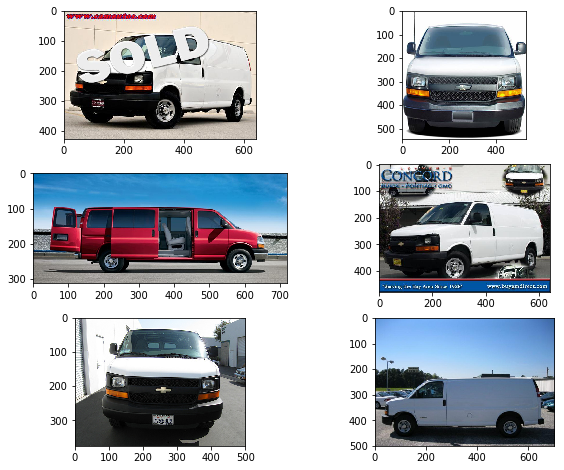

('Dodge Caliber Wagon 2007', 'Dodge Caliber Wagon 2012', 3)


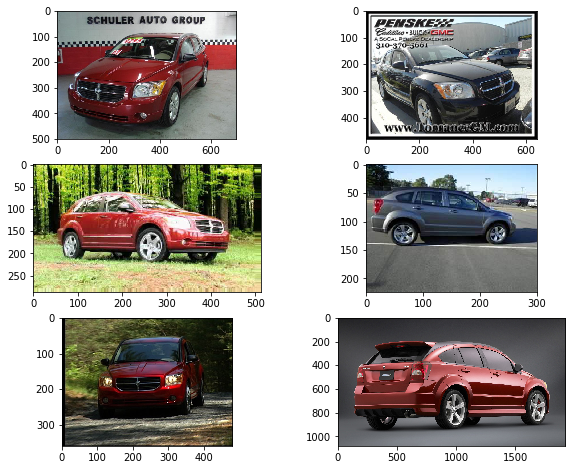

('Dodge Caliber Wagon 2012', 'Dodge Caliber Wagon 2007', 3)


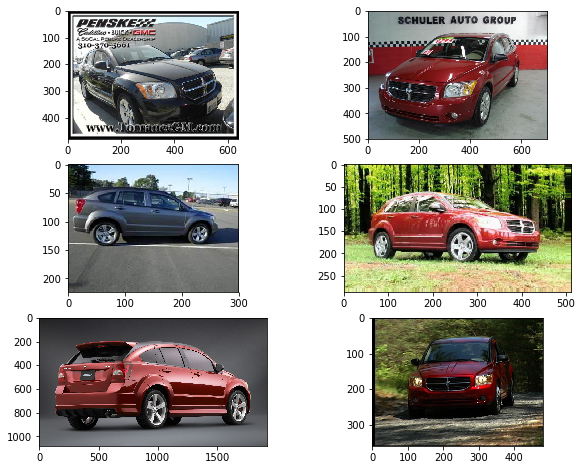

('Aston Martin Virage Convertible 2012', 'Aston Martin V8 Vantage Convertible 2012', 2)


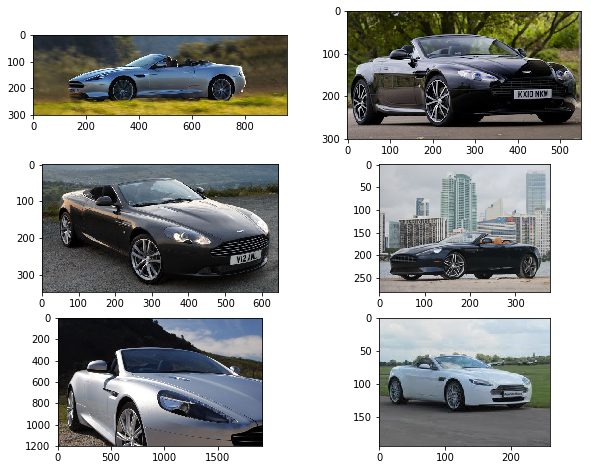

In [73]:
most_confused = interp.most_confused()

for i in range(0,8):
    compare_most_confused(most_confused=most_confused, labels_df=labels_df, 
                          num_imgs=3, rank=i)

From above, all of the cars that the model got wrong look vary similar. Some of them are same model but from different year. All the top wrong predictions are cars from same manufacturer and by looking the images it's really hard to tell them apart from each other.

## Summary

Summary of best model based on experiment above:

**Stage 1**:
- Initialize the model(resnet152 with pretrained weights on ImageNet).
- Train final layer
- best learning rate: 0.001
- number of epochs: 16
- train loss: 0.364173 	
- validation loss: 0.630648
- validation accuracy: 0.810811

**Stage 2**:
- unfreeze all layers and train.
- best learning rate: 0.001
- number of epochs: 15
- using differential learning rate: [lr/9, lr/6, lr]. The earlier layers was trained on very small learning rate, 0.001/9, the middle layers trained on a  bit higher learning rate, 0.001/6, and final layers trained using learning rate, 0.001
- train loss: 0.250652 	
- validation loss: 0.475406
- validation accuracy: 0.867322

**Stage 3**:
- resize image to 299, freeze the layers and train the final layer.
- best learning rate: 0.001
- number of epochs: 8
- train loss: 0.213713 	
- validation loss: 0.444467
- validation accuracy: 0.878378

**Final Testing**: <br>
Accuracy on test set: **0.8827**

### Potential avenues to explore:

There are a few potential avenues to explore to increase the model performance.

**Architecture:**
- Try using another size of ResNet.
- Try DenseNet

**Data Augmentation:**
- Using [Mixup](https://arxiv.org/abs/1710.09412) data augmentation. Mixup are efficient at regularizing models for computer vision.